# Direct application of the pinhole-camera model: augmented reality

In augmented reality, virtual objects (i.e., graphics or text) are projected onto an image of a real scene in a way that the virtual object appears to be geometrically aligned with the scene's perspective view (Figure 1). The geometric alignment is given by the pinhole-camera model, which describes the relationship between the real-scene's world-coordinate frame and the synthetic object's coordinate frame. 

<img src="https://images.theconversation.com/files/245627/original/file-20181114-194494-1p82jkx.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1200&h=1200.0&fit=crop style=&quot;zoom:0%" alt="What is augmented reality, anyway?" style="zoom:54%;" />

**Figure 1**: Augmented reality. The Pokémon-GO game is an example of augmented reality (Image from: https://theconversation.com/what-is-augmented-reality-anyway-99827).

## The pinhole camera 
The pinhole camera model takes 3-D points as input and maps them to 2-D image points, i.e., for each 3-D point  ${\bf w}_i = \left(u_i,v_i,w_i\right)^\mathsf{T}$, the pinhole camera model outputs an image point ${\bf x}_i = (x_i,y_i)^\mathsf{T}$ as follows: 

$$
\begin{align}
{\bf x}_i = \text{pinhole}\left[{\bf w}_i, \Lambda,\Omega,\boldsymbol{\tau}\right],
\end{align}
$$

where $\Lambda$ represents the camera's *intrinsic* parameters, and  $\Omega$ and ${\boldsymbol{\tau}}$ represent the motion of the camera (i.e., camera pose) with respect to the world coordinate frame. The parameters that model the camera motion are called *extrinsic* parameters. Figure 2 shows an example of using the pinhole-camera model to map a set of vertices of a cube shape to image points. 

<img src="./camera.png" alt="image-20210922143020280" style="zoom:50%;" />

**Figure 2**: Perspective projection of a set of vertices representing a cube. The camera has its own coordinate frame $\left\{u_c,v_c,w_c\right\}$ which has been rotated and translated with respect to the world coordinate frame $\left\{u,v,w\right\}$. 

The explicit form of the pinhole-camera model is given by: 

$$
\begin{align}
    x &= \frac{\phi_x\left(\omega_{11}u + \omega_{12}v + \omega_{13}w + \tau_x \right) + \gamma\left(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y\right)}
        {\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_x,\notag\\
    y &= \frac{\phi_y\left(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y \right)}
        {\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_y.
        \label{pinhole_explicit}
\end{align}
$$

### The pinhole camera in matrix form
The pinhole-camera model is a non-linear function. This nonlinearity means that the function cannot be expressed as a single matrix in Cartesian coordinates, which are coordinates of points in Euclidean space. However, we can convert the points (and also transformations) from Euclidean space to Projective space (https://en.wikipedia.org/wiki/Homogeneous_coordinates). In projective space, the location of points is given by homogeneous coordinates (or projective coordinates). This conversion has the advantage that all transformations in projective space are linear and, as a result, can be expressed by transformation matrices.  

The pinhole-camera model is written in homogeneous coordinates as follows:

$$
\begin{align}
    \lambda
    \begin{bmatrix}
        x \\
        y \\
        1
    \end{bmatrix}
    =  
    \underbrace{\begin{bmatrix}
        \phi_x & \gamma & \delta_x & 0 \\
         0     & \phi_y & \delta_y & 0 \\
         0     & 0      & 1        & 0 
    \end{bmatrix}}_{\text{camera matrix}}
    \underbrace{\begin{bmatrix}
        \omega_{11} & \omega_{12} & \omega_{13} & \tau_x \\
        \omega_{21} & \omega_{22} & \omega_{23} & \tau_y \\
        \omega_{31} & \omega_{32} & \omega_{33} & \tau_z \\
         0          & 0           & 0           & 1 
    \end{bmatrix}}_{\text{camera's rigid motion}}
    \begin{bmatrix}
        u \\
        v \\
        w \\
        1
    \end{bmatrix}, 
    \label{pinhole_matrix}
\end{align}
$$

which can be written in short notation (i.e., block matrices) as:

$$
\begin{align}
    \lambda \tilde{{\bf x}} = 
    \begin{bmatrix}
        \Lambda & {\mathbf 0}
    \end{bmatrix}
    \begin{bmatrix}
        \Omega & {\boldsymbol{\tau}}\\
        {\mathbf 0}^\mathsf{T} & 1
    \end{bmatrix} \tilde{{\bf w}}, 
\end{align}
$$

or even shorter as: 

$$
\begin{align}
    \lambda \tilde{{\bf x}} = 
    \Lambda
    \begin{bmatrix}
        \Omega & {\boldsymbol{\tau}}
    \end{bmatrix} \tilde{{\bf w}}. 
\end{align}
$$

Sometimes, we combine the camera matrix $\Lambda$ and the camera-motion matrix $\left[\Omega \,\,\, {\boldsymbol{\tau}}\right]$ into a single matrix $P$, called the *projection matrix*, i.e.: 

$$
\begin{align}
    \lambda \tilde{{\bf x}} = P \tilde{{\bf w}}.  
\end{align}
$$


### Numerical example (single point with synthetic camera)

In this example, our goal to project a vertex of a 3-D virtual object onto the image of the scene. 

In [1]:
# Libraries 
import os
import imageio
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

The 3-D vertex is located at ${\bf w} = \left(10,-10,20\right)^\mathsf{T}$, and its color is blue, i.e., **rgb**(0,0,255).

In [2]:
# Coordinates of the 3-D vertex
w = np.array([[10], [-10], [20]])   # Column vector 
print("w =")
print(w)

# Vertex color 
c = np.array([0,0,255])   # RGB color components (blue color)

w =
[[ 10]
 [-10]
 [ 20]]


Assume that an image of a real scene is captured by a static camera that has the following parameters: 

- **Focal lengths**: $\phi_x = 200$ and $\phi_y = 205$, 
- **Principal point**: $\delta_x = 401$ and $\delta_y=305$,
- **Skew**: 0
- **Rotation**: 0 degrees, 
- **Translation**: $\boldsymbol{\tau}=\left(10,0,0\right)^\mathsf{T}$,
- **Image size (width,height)**:  $800\times600$ pixels.

 Here, we need to perform two basic steps: (1) Calculate the image coordinates $(x,y)$ of the vertex using the pinhole camera model, and (2) Set the color of the pixel at $(x,y)$ to the desired color, i.e., **rgb**(0,0,255). 

In [3]:
# Intrinsic parameters
phi_x   = 200.0
phi_y   = 205.0
skew    =   0.0
delta_x = 401.0
delta_y = 305.0

# Matrices (perspective projection model)
Lambda = np.array([[phi_x,  skew, delta_x], 
                   [    0, phi_y, delta_y],
                   [    0,     0,       1]])
                   
print("Lambda = ")
print(Lambda)

# Extrinsic parameters 
Omega = np.eye(3,3)
tau   = np.array([[10], [0], [0]]) 

print("\n")
print("Omega = ")
print(Omega)

print("\n")
print("tau = ")
print(tau)

# Image size (resolution)
im_width  = 800
im_height = 600

Lambda = 
[[200.   0. 401.]
 [  0. 205. 305.]
 [  0.   0.   1.]]


Omega = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


tau = 
[[10]
 [ 0]
 [ 0]]


1. Find the image coordinates of the vertex as seen by the camera: 	

$$
\begin{align}
    \lambda
    \begin{bmatrix}
        x \\
        y \\
        1
    \end{bmatrix}
    &=  
    \underbrace{\begin{bmatrix}
        200    &   0 & 401 \\
         0     & 205 & 305 \\
         0     & 0   & 1    
    \end{bmatrix}}_{\text{intrisic matrix}}
    \underbrace{\begin{bmatrix}
        1 & 0 & 0 & 10 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
    \end{bmatrix}}_{\text{extrinsic matrix}}
    \begin{bmatrix}
        10 \\
        -10 \\
        20 \\
        1
    \end{bmatrix} \notag\\
    &= 
        \begin{bmatrix}
        12020 \\
        4050 \\
        20 
    \end{bmatrix} \implies 
    \begin{cases}
    	x &= \frac{\lambda x}{\lambda} = \frac{12020}{20} = 601 \\
			y &= \frac{\lambda y}{\lambda} = \frac{4050}{20} = 202.5 
    \end{cases}
\end{align}
$$

In [4]:
# Convert vertex coords to homogeneous coordinates
w_tilde = np.block([[w],[1]])
print("w_tilde = ")
print(w_tilde)

# Calculate perspective projection of vertex onto image 
x_tilde = Lambda @ np.block([Omega, tau]) @ w_tilde

print("\nx_tilde = ")
print(x_tilde)

# Convert coordinates from homogeneous to Cartesian
x = x_tilde[0] / x_tilde[2]
y = x_tilde[1] / x_tilde[2]

print("\nx = ")
print(x,y)
print(np.shape(x))


w_tilde = 
[[ 10]
 [-10]
 [ 20]
 [  1]]

x_tilde = 
[[12020.]
 [ 4050.]
 [   20.]]

x = 
[601.] [202.5]
(1,)


2. Set the color of the image pixel to the desired color: 

   $$
   I(202, 601) \leftarrow rgb(0,0,255).
   $$

Here, $I$ is the image matrix. Its dimension is $600\times 800$ (i.e., rows $\times$ columns), and the matrix is indexed using $(i,j)$ indices. Note $(i,j)$ indices and $(x,y)$ coordinates are not equal. Instead, x-values vary with the columns of the matrix (i.e., index $j$) while y-values vary with the rows of the matrix (i.e., index $i$).  

When projecting several vertices of a 3-D object, the above two steps are repeated for all points. 

### Projecting multiple points

When projecting multiple points, we can stack all points as columns of a matrix and then apply the multiplication transformation directly on the matrix. For instance, the following matrix stores the 3-D coordinates of the vertices of a cube.  

$$
\begin{align}
C = 
\begin{bmatrix}
   {\bf w}_1 & \dots & {\bf w}_N
\end{bmatrix}
=
\begin{bmatrix}
   0 & 50 & 50 & 0 & 0 & 50 & 50 & 0\\ 0 & 0 & 50 & 50 & 0 & 0 & 50 & 50\\ 200 & 200 & 200 & 200 & 250 & 250 & 250 & 250 
   \label{eq_Cube1}
\end{bmatrix}.
\end{align}
$$

Each column of matrix $C$ is a vertex ${\bf w}_i = \left(u_i,v_i,w_i\right)^\mathsf{T}$ of a cube, for $i=1,\dots,8$.  The cube is located in front of the camera as the example shown in Figure 1. The projection operation is then given by: 

$$
\begin{align}
    \lambda \tilde{{\bf x}} = 
    \Lambda
    \begin{bmatrix}
        \Omega & {\boldsymbol{\tau}}
    \end{bmatrix} \tilde{C},  
\end{align}
$$

where $\tilde{C}$ is the cube points given in homogeneous coordinates, i.e.: 

$$
\begin{align}
\tilde{C} = 
\begin{bmatrix}
   \tilde{\bf w}_1 & \dots & \tilde{\bf w}_N
\end{bmatrix}
=
\begin{bmatrix}
   0 & 50 & 50 & 0 & 0 & 50 & 50 & 0\\ 
   0 & 0 & 50 & 50 & 0 & 0 & 50 & 50\\ 
   200 & 200 & 200 & 200 & 250 & 250 & 250 & 250 \\
   1 & 1 & 1 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}.
\end{align}
$$



In [5]:
# Object
C   = np.array([
    [  0,  50,  50,   0,   0,  50,  50,   0], 
    [  0,   0,  50,  50,   0,   0,  50,  50], 
    [200, 200, 200, 200, 250, 250, 250, 250]
    ])

# Convert points to homogeneous coords
C_tilde = np.block([[C],[np.ones([1,np.shape(C)[1]])]])

print("C_tilde = ")
print(C_tilde)

# Calculate perspective projection 
x_tilde = Lambda @ np.block([Omega, tau]) @ C_tilde

print("\nx_tilde = ")
print(x_tilde)

C_tilde = 
[[  0.  50.  50.   0.   0.  50.  50.   0.]
 [  0.   0.  50.  50.   0.   0.  50.  50.]
 [200. 200. 200. 200. 250. 250. 250. 250.]
 [  1.   1.   1.   1.   1.   1.   1.   1.]]

x_tilde = 
[[ 82200.  92200.  92200.  82200. 102250. 112250. 112250. 102250.]
 [ 61000.  61000.  71250.  71250.  76250.  76250.  86500.  86500.]
 [   200.    200.    200.    200.    250.    250.    250.    250.]]


In [6]:
# Convert coordinates from homogeneous to Cartesian
x = np.zeros([2,np.shape(C)[1]])          # Create matrix to store image coords                          

x[0][:] = x_tilde[0][:] / x_tilde[2][:]   # Vectorized division (avoid using loops!) 
x[1][:] = x_tilde[1][:] / x_tilde[2][:]

print("\nx = ")
print(x)



x = 
[[411.   461.   461.   411.   409.   449.   449.   409.  ]
 [305.   305.   356.25 356.25 305.   305.   346.   346.  ]]


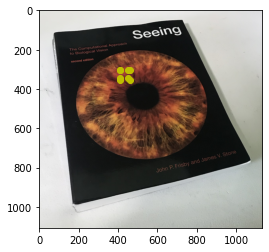

In [7]:
# Plot results 
plt.plot(x[0][:], x[1][:], 'yo')

# Read and display an image (this is just an example image)
im = cv2.imread('stone.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

plt.show()

#### Assignment description 

In this assignment, you will render a virtual object in the first frame of each video in the soldiers-tracking dataset (https://www.epfl.ch/labs/cvlab/data/soldiers-tracking/). The dataset has six videos of an indoor scene captured from synchronized cameras from multiple view points. The dataset contains the videos and the camera-calibration data for all cameras.

The assignment's deliverable is a Jupyter notebook containing code extracts and output images showing the augmented first frames. You should also try to include some equations and comments about the steps you took to complete the project.

The virtual object to be rendered on the images is a cube centered at the center of the squared calibration pattern that appears in the image.  You will project the same cube on the first frame of each video using the camera model for each camera. Ideally, you should create your report (and programs) in the form of Jupyter Notebook.  You will need to calculate the position of the virtual cube so that the output looks like the image in Figure 3. 

![](exampleCube.png)

**Figure 3**: Expected output of the assignment for frame 1 of video `3_2.mpg`. The virtual cube has its base centered at the center of the square calibration pattern and covers almost the entire pattern. The cube will be positioned at the same location for all six views. 

The calibration data (i.e., intrinsic and extrinsic parameters) for each camera is the json file `calibration.json`, which is a text file that can be opened by standard text editors. You can also read the content of the json file into your program by calling a library function in Python or Matlab. The dataset comes with the Python script `example.py` that reads the json file and project test points onto the images. 

You will need to extract the calibration data from the json file. For each camera, extract the matrix of intrinsic parameters $K$, the camera rotation matrix $R$, and the translation vector $t$. These matrices correspond to the matrices $\Lambda$, $\Omega$, and $\boldsymbol{\tau}$, respectively.  

In [13]:
# Parses the json file
def json_read(filename):
    try:
        with open(os.path.abspath(filename)) as f:    
            data = json.load(f)
        return data
    except:
        raise ValueError("Unable to read JSON {}".format(filename))

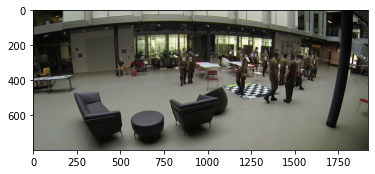

In [9]:
# Show the first frame from one of the videos
view = '3_2_'
vidcap = cv2.VideoCapture("{}.mp4".format(view))
success,img = vidcap.read()

# Opencv uses BGR so we convert to RGB here 
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
plt.figure()
plt.imshow(im_rgb)

In [10]:
# Read json file containing the calibration data
calibration = json_read("calibration.json")

In [11]:
# Get the calibration matrices
Lambda = np.array(calibration[view]['K'])      # Intrinsic params.
Omega  = np.array(calibration[view]['R'])      # Rotation
tau    = np.array(calibration[view]['t'])      # Translation
dist   = np.array(calibration[view]['dist'])   # Lens distortion


print("----------------------------------------")
print("Calibration matrices")
print("----------------------------------------")
print("Lambda = \n",np.matrix(Lambda),"\n")
print("Omega = \n",np.matrix(Omega),"\n") 
print("tau = \n",np.matrix(tau),"\n") 

----------------------------------------
Calibration matrices
----------------------------------------
Lambda = 
 [[868.08784042   0.         976.81457233]
 [  0.         864.65174318 387.22218521]
 [  0.           0.           1.        ]] 

Omega = 
 [[ 0.32289979  0.94638426  0.00962108]
 [ 0.21259462 -0.06262249 -0.97513176]
 [-0.92224685  0.31691523 -0.22141699]] 

tau = 
 [[2.00080565 0.2555784  7.81651077]] 



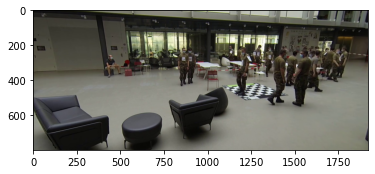

In [12]:
# Image corrected for (spherical) lens distortion
img_corrected = cv2.undistort(im_rgb, Lambda, dist)
plt.figure()
plt.imshow(img_corrected)